# Case 2 - Prediction of COVID-19 Trend in Hong Kong

Import necessary libraries for building DL model

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import RMSprop

from tcn import TCN, tcn_full_summary

Libraries for data processing

In [2]:
import pandas as pd
import numpy as np
from glob import glob
from datetime import datetime
import os


In [3]:
# for graph plotting
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

# Load the TensorBoard notebook extension
%load_ext tensorboard

### Data Collection and Preprocessing

Open the COVID-19 csv file downloaded from the data.gov website.

In [4]:
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')

df = pd.read_csv('data/enhanced_sur_covid_19_eng.csv',  
                 parse_dates=['Report date'],
                 index_col="Case no.", 
                 date_parser=dateparse)

Examine the csv file.

In [5]:
df.head()

,Report date,Date of onset,Gender,Age,Name of hospital admitted,Hospitalised/Discharged/Deceased,HK/Non-HK resident,Case classification*,Confirmed/probable
Case no.,,,,,,,,,
1,2020-01-23,21/01/2020,M,39,NaN,Discharged,Non-HK resident,Imported case,Confirmed
2,2020-01-23,18/01/2020,M,56,NaN,Discharged,HK resident,Imported case,Confirmed
3,2020-01-24,20/01/2020,F,62,NaN,Discharged,Non-HK resident,Imported case,Confirmed
4,2020-01-24,23/01/2020,F,62,NaN,Discharged,Non-HK resident,Imported case,Confirmed
5,2020-01-24,23/01/2020,M,63,NaN,Discharged,Non-HK resident,Imported case,Confirmed


Group the rows by "Report date" and count the number of cases reported on each day.

Convert the case to numpy format. Before 23 Jan 2020, there should be no reported case. So add '0' at the beginning of the case list. The case list looks like this:

In [6]:
case = df.groupby('Report date')['Report date'].count()
case = case.to_numpy()
case.flatten()
case = np.asarray(case, dtype = float)  
case = np.concatenate([[0],case])
print("Total number of cases (until now):", len(case))
print(case)

# create time axis
time = np.arange(0, len(case)).astype(np.float32)

# sanity check
len(time), len(case)

Total number of cases (until now): 213
[  0.   2.   3.   3.   2.   2.   1.   1.   1.   3.   3.   3.   2.  10.
   6.   7.   1.   3.   3.   1.   3.   2.   3.   4.   1.   5.   6.   4.
   6.   2.   1.   1.   5.   1.   4.   3.   2.   5.   1.   5.   9.   2.
   6.   4.   7.   9.  10.  25.  16.  48.  17.  44.  39.  30.  24.  43.
  65.  64.  59.  41.  32.  51.  37.  43.  17.  28.  24.  21.  25.  13.
  16.  11.   4.   5.   3.   4.   1.   4.   2.   2.   4.   4.   2.   2.
   2.   1.   4.   3.   3.   1.   1.   3.   8.   2.   1.  13.   3.   2.
   3.   6.   6.   3.   3.   1.   1.   1.   1.   3.   8.   4.   3.   1.
   3.  30.  16.   2.  14.   3.   1.   2.   4.   2.  28.   9.   5.  11.
  10.  17.  14.  24.  42.  38.  28.  38.  52.  48.  19.  67.  58.  64.
 107.  73.  61. 113. 118. 123. 133. 128. 145. 106. 117. 149. 121. 125.
 113.  80.  80.  85.  95.  89.  69.  72.  69.  33.  62.  69.  48.  46.
  74.  44.  36.  26.  18.  27.  26.  25.   9.  19.  24.  21.  13.  18.
  15.   9.  12.   8.   8.  12.   7.  2

(213, 213)

### Plot the COVID-19 Cases over time

We can then plot the historical trend of the COVID-19 cases in Hong Kong since Day 0

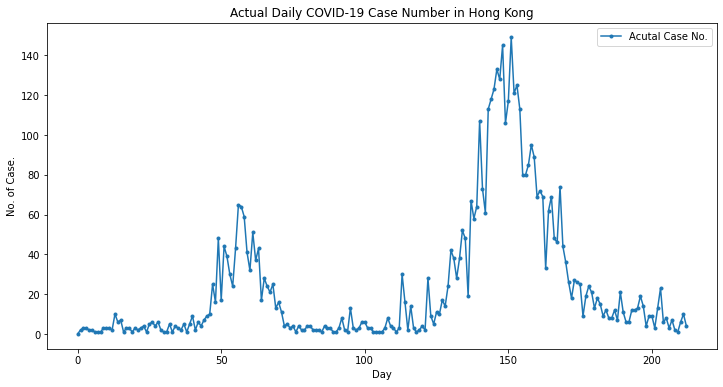

In [7]:
plt.figure(figsize=(12, 6))
plt.ylabel('No. of Case.')
plt.xlabel('Day')
plt.plot(time, case, label='Acutal Case No.', marker='.', zorder=-10)
leg = plt.legend();
plt.title("Actual Daily COVID-19 Case Number in Hong Kong")
plt.show()

Define some helper functions for data slicing for feeding into neural networks

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1) ##
  return dataset

In [9]:
def cnn_lstm_windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

## Approach 1: CNN-LSTM Model

In [10]:
tf.keras.backend.clear_session()
window_size = 10
batch_size = 4
shuffle_buffer_size = 100
cnn_lstm_train_set = cnn_lstm_windowed_dataset(case, window_size, batch_size, shuffle_buffer_size)
print(cnn_lstm_train_set)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64),
  #tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 30)                1950      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 27,005
Trainable params: 27,005
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Uncomment this if you want to see the training progress in tensorboard
logdir = "logs"
os.makedirs(logdir, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


In [12]:
# Start the tensorboard before training. You can reuse this tensorboard for other trainings in this notebook.
%tensorboard --logdir logs

In [13]:
%time history = model.fit(cnn_lstm_train_set,epochs=1000,  verbose=1, callbacks=[tensorboard_callback])

Epoch 1/1000
51/51 [==============================] - 2s 47ms/step - loss: 13.2898 - mae: 13.8131
Epoch 2/1000
51/51 [==============================] - 1s 14ms/step - loss: 9.7203 - mae: 10.1179
Epoch 3/1000
51/51 [==============================] - 1s 14ms/step - loss: 9.3539 - mae: 9.8906
Epoch 4/1000
51/51 [==============================] - 1s 12ms/step - loss: 9.6572 - mae: 10.0570
Epoch 5/1000
51/51 [==============================] - 1s 14ms/step - loss: 8.6749 - mae: 9.1451
Epoch 6/1000
51/51 [==============================] - 1s 15ms/step - loss: 7.5920 - mae: 8.0536
Epoch 7/1000
51/51 [==============================] - 1s 14ms/step - loss: 7.2704 - mae: 7.6857
Epoch 8/1000
51/51 [==============================] - 1s 14ms/step - loss: 8.0037 - mae: 8.5315
Epoch 9/1000
51/51 [==============================] - 1s 11ms/step - loss: 8.2450 - mae: 8.7129
Epoch 10/1000
51/51 [==============================] - 1s 14ms/step - loss: 8.4198 - mae: 8.8861
Epoch 11/1000
51/51 [==============

51/51 [==============================] - 1s 15ms/step - loss: 6.4600 - mae: 6.9946
Epoch 169/1000
51/51 [==============================] - 1s 15ms/step - loss: 6.5841 - mae: 7.0073
Epoch 170/1000
51/51 [==============================] - 1s 15ms/step - loss: 6.7631 - mae: 7.2986
Epoch 171/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.8175 - mae: 7.3904
Epoch 172/1000
51/51 [==============================] - 1s 15ms/step - loss: 6.6904 - mae: 7.2080
Epoch 173/1000
51/51 [==============================] - 1s 15ms/step - loss: 6.5475 - mae: 7.0673
Epoch 174/1000
51/51 [==============================] - 1s 15ms/step - loss: 6.6212 - mae: 7.0309
Epoch 175/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.7209 - mae: 7.1658
Epoch 176/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.8449 - mae: 7.2696
Epoch 177/1000
51/51 [==============================] - 1s 12ms/step - loss: 6.6692 - mae: 7.0860
Epoch 178/1000
51/51 [=============

51/51 [==============================] - 1s 15ms/step - loss: 6.4651 - mae: 6.9250
Epoch 335/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.5232 - mae: 6.9690
Epoch 336/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.5958 - mae: 7.0913
Epoch 337/1000
51/51 [==============================] - 1s 13ms/step - loss: 6.8222 - mae: 7.2777
Epoch 338/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.6134 - mae: 7.0202
Epoch 339/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.7156 - mae: 7.1813
Epoch 340/1000
51/51 [==============================] - 1s 13ms/step - loss: 6.5783 - mae: 7.0750
Epoch 341/1000
51/51 [==============================] - 1s 11ms/step - loss: 6.5145 - mae: 7.0444
Epoch 342/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.5535 - mae: 6.9937
Epoch 343/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.4924 - mae: 7.0033
Epoch 344/1000
51/51 [=============

51/51 [==============================] - 1s 12ms/step - loss: 6.5266 - mae: 6.9694
Epoch 501/1000
51/51 [==============================] - 1s 11ms/step - loss: 6.4817 - mae: 6.9353
Epoch 502/1000
51/51 [==============================] - 1s 11ms/step - loss: 6.6329 - mae: 7.0324
Epoch 503/1000
51/51 [==============================] - 1s 10ms/step - loss: 6.6168 - mae: 7.1025
Epoch 504/1000
51/51 [==============================] - 1s 12ms/step - loss: 6.4866 - mae: 6.9531
Epoch 505/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.5036 - mae: 6.9012
Epoch 506/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.4355 - mae: 6.9339
Epoch 507/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.5268 - mae: 7.0328
Epoch 508/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.5989 - mae: 7.0042
Epoch 509/1000
51/51 [==============================] - 1s 13ms/step - loss: 6.7420 - mae: 7.1515
Epoch 510/1000
51/51 [=============

51/51 [==============================] - 1s 14ms/step - loss: 6.5330 - mae: 6.9494
Epoch 667/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.4028 - mae: 6.9028
Epoch 668/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.5050 - mae: 6.9546
Epoch 669/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.4459 - mae: 6.9112
Epoch 670/1000
51/51 [==============================] - 1s 12ms/step - loss: 6.5605 - mae: 6.9585
Epoch 671/1000
51/51 [==============================] - 1s 12ms/step - loss: 6.3826 - mae: 7.0377
Epoch 672/1000
51/51 [==============================] - 1s 11ms/step - loss: 6.5108 - mae: 6.9545
Epoch 673/1000
51/51 [==============================] - 1s 13ms/step - loss: 6.4570 - mae: 6.9140
Epoch 674/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.5316 - mae: 6.9456
Epoch 675/1000
51/51 [==============================] - 1s 15ms/step - loss: 6.6045 - mae: 6.9958
Epoch 676/1000
51/51 [=============

51/51 [==============================] - 1s 14ms/step - loss: 6.4292 - mae: 6.9019
Epoch 833/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.3777 - mae: 6.9118
Epoch 834/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.4322 - mae: 6.9835
Epoch 835/1000
51/51 [==============================] - 1s 15ms/step - loss: 6.4219 - mae: 6.9641
Epoch 836/1000
51/51 [==============================] - 1s 15ms/step - loss: 6.5644 - mae: 7.0022
Epoch 837/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.4249 - mae: 6.9010
Epoch 838/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.4794 - mae: 6.9889
Epoch 839/1000
51/51 [==============================] - 1s 13ms/step - loss: 6.3562 - mae: 6.9177
Epoch 840/1000
51/51 [==============================] - 1s 15ms/step - loss: 6.4730 - mae: 6.9602
Epoch 841/1000
51/51 [==============================] - 1s 14ms/step - loss: 6.5240 - mae: 6.9355
Epoch 842/1000
51/51 [=============

51/51 [==============================] - 1s 10ms/step - loss: 6.4703 - mae: 6.8775
Epoch 999/1000
51/51 [==============================] - 1s 11ms/step - loss: 6.4716 - mae: 6.9025
Epoch 1000/1000
51/51 [==============================] - 1s 11ms/step - loss: 6.3078 - mae: 6.9078
CPU times: user 27min 7s, sys: 6min 4s, total: 33min 11s
Wall time: 11min 33s


Use the trained CNN-LSTM model to forecast the case trend

In [14]:
def cnnlstem_model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Save the model and forecast result

In [15]:
cnnlstem_model = model
cnnlstem_forecast = cnnlstem_model_forecast(cnnlstem_model, case[..., np.newaxis], window_size)
cnnlstem_result = np.rint(cnnlstem_forecast).squeeze()

## Approach 2: Temporal Convolutional Network

We use a new type of convolution network called Temporal Convolutional Network to forecast.

Reference: An Empirical Evaluation of Generic Convolutional and Recurrent Networksfor Sequence Modeling in 2018 (https://bit.ly/3ct3gi5 )

Github: https://github.com/philipperemy/keras-tcn

Define some parameters for creating the datasets for training

In [16]:
window_size = 10
batch_size = 4
shuffle_buffer = 100
dataset = windowed_dataset(case, window_size, batch_size, shuffle_buffer)

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()

tcn_model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  TCN(nb_filters = 64,
       kernel_size = 2,
       nb_stacks = 2,
       dilations = [1, 2, 4, 8]),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

# Define how the model is trained. We use RMS prop with learning rate 0.0005 as the optimizer, 
# Huber loss as the loss function and Mean Absolute Error as the evaluation metrics.
tcn_model.compile(
    optimizer = RMSprop(learning_rate = 0.0005),
    loss = tf.keras.losses.Huber(),
    metrics = ['mae'])

# Uncomment this if you want to see the training progress in tensorboard
#logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
#os.makedirs(logdir, exist_ok=True)
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# print out the model summary
tcn_full_summary(tcn_model, expand_residual_blocks=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
residual_block_0 (ResidualBl [(None, None, 64), (None, 8576      
_________________________________________________________________
residual_block_1 (ResidualBl [(None, None, 64), (None, 16512     
_________________________________________________________________
residual_block_2 (ResidualBl [(None, None, 64), (None, 16512     
_________________________________________________________________
residual_block_3 (ResidualBl [(None, None, 64), (None, 16512     
_________________________________________________________________
residual_block_4 (ResidualBl [(None, None, 64), (None, 16512     
_________________________________________________________________
residual_block_5 (ResidualBl [(None, None, 64), (None, 1

In [18]:
%time history = tcn_model.fit(dataset,epochs=1000,  verbose=1, callbacks=[tensorboard_callback])

Epoch 1/1000
51/51 [==============================] - 4s 78ms/step - loss: 88.7604 - mae: 89.2553
Epoch 2/1000
51/51 [==============================] - 1s 19ms/step - loss: 41.0311 - mae: 41.1733
Epoch 3/1000
51/51 [==============================] - 1s 19ms/step - loss: 26.9683 - mae: 28.1314
Epoch 4/1000
51/51 [==============================] - 1s 18ms/step - loss: 18.0324 - mae: 18.5873
Epoch 5/1000
51/51 [==============================] - 1s 18ms/step - loss: 16.0414 - mae: 16.6940
Epoch 6/1000
51/51 [==============================] - 1s 18ms/step - loss: 14.1507 - mae: 14.5987
Epoch 7/1000
51/51 [==============================] - 1s 18ms/step - loss: 12.7493 - mae: 13.3641
Epoch 8/1000
51/51 [==============================] - 1s 18ms/step - loss: 11.6212 - mae: 12.0890
Epoch 9/1000
51/51 [==============================] - 1s 18ms/step - loss: 11.3238 - mae: 11.6861
Epoch 10/1000
51/51 [==============================] - 1s 18ms/step - loss: 9.7736 - mae: 10.1370
Epoch 11/1000
51/51 

51/51 [==============================] - 1s 18ms/step - loss: 2.6396 - mae: 3.0158
Epoch 169/1000
51/51 [==============================] - 1s 18ms/step - loss: 2.7803 - mae: 3.1917
Epoch 170/1000
51/51 [==============================] - 1s 19ms/step - loss: 2.9117 - mae: 3.3359
Epoch 171/1000
51/51 [==============================] - 1s 18ms/step - loss: 3.0333 - mae: 3.4108
Epoch 172/1000
51/51 [==============================] - 1s 18ms/step - loss: 2.4706 - mae: 2.9612
Epoch 173/1000
51/51 [==============================] - 1s 18ms/step - loss: 2.8918 - mae: 3.2686
Epoch 174/1000
51/51 [==============================] - 1s 18ms/step - loss: 2.4248 - mae: 2.8693
Epoch 175/1000
51/51 [==============================] - 1s 18ms/step - loss: 2.9283 - mae: 3.3378
Epoch 176/1000
51/51 [==============================] - 1s 19ms/step - loss: 2.6175 - mae: 3.0575
Epoch 177/1000
51/51 [==============================] - 1s 19ms/step - loss: 2.8032 - mae: 3.1854
Epoch 178/1000
51/51 [=============

51/51 [==============================] - 1s 18ms/step - loss: 1.6375 - mae: 2.1232
Epoch 335/1000
51/51 [==============================] - 1s 17ms/step - loss: 1.5790 - mae: 1.9787
Epoch 336/1000
51/51 [==============================] - 1s 19ms/step - loss: 1.9291 - mae: 2.3155
Epoch 337/1000
51/51 [==============================] - 1s 19ms/step - loss: 1.6657 - mae: 2.0095
Epoch 338/1000
51/51 [==============================] - 1s 18ms/step - loss: 1.6482 - mae: 2.0132
Epoch 339/1000
51/51 [==============================] - 1s 17ms/step - loss: 1.5198 - mae: 1.8962
Epoch 340/1000
51/51 [==============================] - 1s 18ms/step - loss: 1.6328 - mae: 2.0271
Epoch 341/1000
51/51 [==============================] - 1s 18ms/step - loss: 1.6629 - mae: 2.0073
Epoch 342/1000
51/51 [==============================] - 1s 17ms/step - loss: 1.4765 - mae: 1.8400
Epoch 343/1000
51/51 [==============================] - 1s 18ms/step - loss: 1.7504 - mae: 2.1112
Epoch 344/1000
51/51 [=============

51/51 [==============================] - 1s 18ms/step - loss: 1.1057 - mae: 1.5037
Epoch 501/1000
51/51 [==============================] - 1s 18ms/step - loss: 1.1421 - mae: 1.4713
Epoch 502/1000
51/51 [==============================] - 1s 18ms/step - loss: 1.0356 - mae: 1.3811
Epoch 503/1000
51/51 [==============================] - 1s 18ms/step - loss: 1.0674 - mae: 1.4078
Epoch 504/1000
51/51 [==============================] - 1s 18ms/step - loss: 1.1131 - mae: 1.4413
Epoch 505/1000
51/51 [==============================] - 1s 18ms/step - loss: 1.3617 - mae: 1.7529
Epoch 506/1000
51/51 [==============================] - 1s 18ms/step - loss: 1.1820 - mae: 1.5473
Epoch 507/1000
51/51 [==============================] - 1s 18ms/step - loss: 1.0296 - mae: 1.3723
Epoch 508/1000
51/51 [==============================] - 1s 18ms/step - loss: 1.3872 - mae: 1.8174
Epoch 509/1000
51/51 [==============================] - 1s 18ms/step - loss: 1.2451 - mae: 1.5885
Epoch 510/1000
51/51 [=============

51/51 [==============================] - 1s 18ms/step - loss: 0.9757 - mae: 1.3190
Epoch 667/1000
51/51 [==============================] - 1s 18ms/step - loss: 0.9090 - mae: 1.2079
Epoch 668/1000
51/51 [==============================] - 1s 17ms/step - loss: 0.8829 - mae: 1.2199
Epoch 669/1000
51/51 [==============================] - 1s 19ms/step - loss: 0.8238 - mae: 1.1716
Epoch 670/1000
51/51 [==============================] - 1s 18ms/step - loss: 1.0480 - mae: 1.3826
Epoch 671/1000
51/51 [==============================] - 1s 18ms/step - loss: 0.9182 - mae: 1.2475
Epoch 672/1000
51/51 [==============================] - 1s 18ms/step - loss: 0.9412 - mae: 1.2752
Epoch 673/1000
51/51 [==============================] - 1s 18ms/step - loss: 0.8151 - mae: 1.1290
Epoch 674/1000
51/51 [==============================] - 1s 19ms/step - loss: 1.0601 - mae: 1.3921
Epoch 675/1000
51/51 [==============================] - 1s 19ms/step - loss: 0.8171 - mae: 1.1192
Epoch 676/1000
51/51 [=============

51/51 [==============================] - 1s 18ms/step - loss: 0.6917 - mae: 0.9955
Epoch 833/1000
51/51 [==============================] - 1s 18ms/step - loss: 0.8950 - mae: 1.1876
Epoch 834/1000
51/51 [==============================] - 1s 19ms/step - loss: 0.6604 - mae: 0.9827
Epoch 835/1000
51/51 [==============================] - 1s 18ms/step - loss: 0.8797 - mae: 1.1892
Epoch 836/1000
51/51 [==============================] - 1s 18ms/step - loss: 0.6707 - mae: 1.0023
Epoch 837/1000
51/51 [==============================] - 1s 18ms/step - loss: 0.8515 - mae: 1.1812
Epoch 838/1000
51/51 [==============================] - 1s 18ms/step - loss: 0.6911 - mae: 1.0403
Epoch 839/1000
51/51 [==============================] - 1s 18ms/step - loss: 0.7754 - mae: 1.1056
Epoch 840/1000
51/51 [==============================] - 1s 17ms/step - loss: 0.7171 - mae: 1.0270
Epoch 841/1000
51/51 [==============================] - 1s 18ms/step - loss: 0.7266 - mae: 1.0238
Epoch 842/1000
51/51 [=============

51/51 [==============================] - 1s 19ms/step - loss: 0.6372 - mae: 0.9298
Epoch 999/1000
51/51 [==============================] - 1s 19ms/step - loss: 0.6701 - mae: 0.9699
Epoch 1000/1000
51/51 [==============================] - 1s 17ms/step - loss: 0.7157 - mae: 1.0070
CPU times: user 30min 52s, sys: 4min 33s, total: 35min 25s
Wall time: 15min 22s


We can use the trained TCN model to run forecasting

In [19]:
tcn_forecast = []
for time in range(len(case) - window_size):
    tcn_forecast.append(tcn_model.predict(case[time:time + window_size][np.newaxis]))
    
tcn_result = np.rint(tcn_forecast).squeeze()
print(tcn_result)

[  3.   3.   2.   7.   5.   6.   1.   3.   3.   1.   3.   2.   3.   4.
   2.   5.   6.   4.   6.   2.   2.   1.   4.   2.   4.   4.   2.   6.
   4.   4.   9.   2.   7.   4.   5.   9.   9.  18.  15.  36.  20.  42.
  39.  30.  24.  41.  57.  62.  58.  60.  33.  48.  36.  43.  18.  26.
  29.  20.  25.  15.  16.  20.   6.  16.   3.   4.   9.   3.   9.   2.
   7.   7.   2.   4.   3.   3.   4.   4.   3.   1.   2.   3.   6.   2.
   1.  14.   4.   2.   3.   6.   6.   3.   6.   1.   1.   9.   1.   3.
   8.   4.   5.   1.   3.  28.  15.   2.  13.   3.   1.   2.   4.   2.
  28.  18.  10.  11.  11.  16.  14.  22.  41.  39.  33.  38.  51.  48.
  22.  73.  57.  58. 100.  70.  61. 117. 111. 117. 135. 126. 141. 114.
 117. 141. 123. 120. 114.  94.  80.  84.  88.  87.  66.  77.  72.  42.
  63.  64.  52.  49.  61.  54.  35.  33.  29.  26.  25.  26.  12.  20.
  27.  23.  14.  20.  15.   7.  13.  13.   7.  14.   7.   9.  10.   8.
   8.  10.  11.  13.  17.  15.   4.  11.   9.   3.  12.  19.   7.   7.
   4. 

In [20]:
len(tcn_result), len(cnnlstem_result), len(case)

(203, 204, 213)

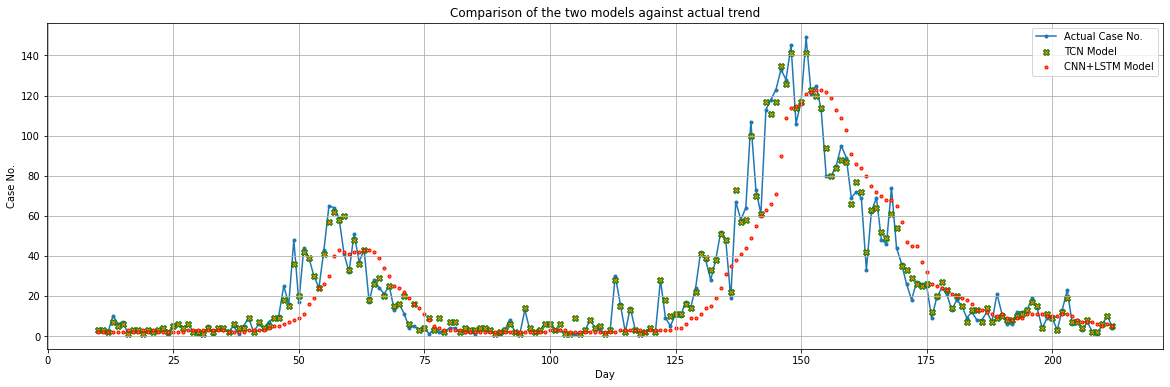

In [25]:
time_axis = np.arange(window_size, len(case)).astype(np.float32)

plt.figure(figsize=(20, 6))
plt.ylabel('Case No.')
plt.xlabel('Day')
plt.title('Comparison of the two models against actual trend')
plt.plot(time_axis, case[window_size:], label='Actual Case No.', marker='.', zorder=-10)
plt.scatter(time_axis, tcn_result, marker='X', edgecolors='g', label='TCN Model', c='#ff7f0e')
plt.scatter(time_axis, cnnlstem_result[:-1], marker='.', edgecolors='r', label='CNN+LSTM Model', c='#ff7f0e')
leg = plt.legend();
plt.grid(True)
plt.show()

## Let's use the model to do some prediction

We use the TCN model and CNN-LSTM model to predict the COVID-19 case numbers in the coming 3 days (30 Sep, 1 Oct and 2 Oct) in Hong Kong.

In [24]:
input_tcn = case[-window_size:]
input_cnn_lstm = case[-window_size:]
print("Future 3-day (D+1, D+2, D+3) forecast on COVID-19 cases in Hong Kong using the above two models:")

for i in range(3):
    predict_tcn = int(tcn_model.predict(input_tcn[np.newaxis]))
    predict_cnn_lstm = int(cnnlstem_model.predict(np.expand_dims(input_cnn_lstm[np.newaxis],-1)))
    print("Predicted No. of Case on D+{} (TCN Model): {}".format(i+1, predict_tcn))
    print("Predicted No. of Case on D+{} (CNN-LSTM Model): {}".format(i+1, predict_cnn_lstm))
    print("=" * 50)
    input_tcn = np.append(input_tcn[1:], predict_tcn)
    input_cnn_lstm = np.append(input_cnn_lstm[1:], predict_cnn_lstm)

Future 3-day (D+1, D+2, D+3) forecast on COVID-19 cases in Hong Kong using the above two models:
Predicted No. of Case on D+1 (TCN Model): 11
Predicted No. of Case on D+1 (CNN-LSTM Model): 4
Predicted No. of Case on D+2 (TCN Model): 6
Predicted No. of Case on D+2 (CNN-LSTM Model): 2
Predicted No. of Case on D+3 (TCN Model): 8
Predicted No. of Case on D+3 (CNN-LSTM Model): 2


Reported cases in Hong Kong:
* 30 Sep: 8
* 1 Oct: 10
* 2 Oct: 7

## Future Work

Further split the data in the sliding data window into train and test data set for better evaluation of model performance.